In [1]:
import numpy as np
import matplotlib.pyplot as plt
import read_beam_FEKO as rf
import ultranest


In [2]:
o = rf.read_beam_FEKO('nominal.out',0)

 Frequency in Hz:               FREQ =    2.50000E+07

 Frequency in Hz:               FREQ =    2.60000E+07

 Frequency in Hz:               FREQ =    2.70000E+07

 Frequency in Hz:               FREQ =    2.80000E+07

 Frequency in Hz:               FREQ =    2.90000E+07

 Frequency in Hz:               FREQ =    3.00000E+07

 Frequency in Hz:               FREQ =    3.10000E+07

 Frequency in Hz:               FREQ =    3.20000E+07

 Frequency in Hz:               FREQ =    3.30000E+07

 Frequency in Hz:               FREQ =    3.40000E+07

 Frequency in Hz:               FREQ =    3.50000E+07

 Frequency in Hz:               FREQ =    3.60000E+07

 Frequency in Hz:               FREQ =    3.70000E+07

 Frequency in Hz:               FREQ =    3.80000E+07

 Frequency in Hz:               FREQ =    3.90000E+07

 Frequency in Hz:               FREQ =    4.00000E+07

 Frequency in Hz:               FREQ =    4.10000E+07

 Frequency in Hz:               FREQ =    4.20000E+07

 Frequency

In [3]:
theta = 90 - o[2]
phi = o[1]
freq = o[0]
theta, phi = np.meshgrid(theta, phi)

In [4]:
xx = theta
yy = phi
sigma = 100
def Acos(R, theta, miu, nu):
    part1 = np.cos(miu*theta*np.pi/180)*(R/sigma)**miu
    part2 = P(miu,nu,R**2/sigma**2)
    part3 = np.exp(-R**2/(4*sigma**2))
    return part1*part2*part3

def Asin(R, theta, miu, nu):
    part1 = np.sin(miu*theta*np.pi/180)*(R/sigma)**miu
    part2 = P(miu,nu,R**2/sigma**2)
    part3 = np.exp(-R**2/(4*sigma**2))
    return part1*part2*part3

def P(miu,nu,u):
    returnarray = np.ones([360,91])
    for i in range(360):
        for j in range(91):
            terms = []
            p = 0
            while p <= nu:
                up = np.math.factorial(miu + nu)*np.math.factorial(nu)
                down = np.math.factorial(miu + p)*np.math.factorial(p)*np.math.factorial(nu-p)
                term = (-2)**(nu-p)* up/down * u[i][j]**p
                terms.append(term)
                p += 1
            returnarray[i][j] = np.sum(terms)
    return returnarray

#Normalization
def normalize(array):
    q = 0
    theta = 0
    while theta <= 90:
        for i in range(360):
            q += (array[theta*360 + i])**2 * (np.pi/180)**2 * np.sin(theta*np.pi/180)
        theta += 1
    return array/q

def TDH(rank):
    """return matrix A = [f1, f2, f3, ...] for rank 0 to rank TDH functions"""
    zz00c = Acos(xx, yy, 0, 0)
    zz00c2d = zz00c.flatten()
    array = normalize(zz00c2d)
    r = 1
    while r <= rank:
        m = 0
        while m <= r:
            if (r - m)%2 == 0:
                n = (r - m)/2
                if m == 0:
                    cosine = Acos(xx,yy,m,n).T
                    cosine2d = cosine.flatten()
                    ncos = normalize(cosine2d)
                    array = np.vstack((array, ncos))
                    m += 2
                else:
                    cosine = Acos(xx,yy,m,n).T
                    cosine2d = cosine.flatten()
                    ncos = normalize(cosine2d)
                    sine = Asin(xx,yy,m,n).T
                    sine2d = sine.flatten()
                    nsin = normalize(sine2d)
                    array = np.vstack((array, ncos))
                    array = np.vstack((array, nsin))
                    m += 2
            else:
                m += 1
        r += 1
    matrix = np.matrix(array).T
    return matrix

def model(rank, coe):
    A = TDH(rank)
    a = np.matrix(coe).T
    return np.matmul(A,a)

def simulation(coe, sigma):
    rank = 0
    count = 1
    length = len(coe) - 1
    while length > count:
        rank += 1
        count += rank + 1
    mo = model(rank,coe)
    noise = np.random.default_rng().normal(0.0, sigma*np.max(mo),360*91)
    noi = np.matrix(noise).T
    data = mo + noi
    return data

def solve(A, data):
    AT = A.T
    ATA = np.matmul(AT,A)
    ATAinverse = np.linalg.inv(ATA)
    half = np.matmul(ATAinverse,AT)
    x = np.matmul(half,data)
    return x

def residual(A,data):
    x = solve(A, data)
    AT = A.T
    fittingmodel = np.matmul(A, x)
    r = fittingmodel - data
    return r

def residual2D(A,data):
    x = solve(A, data)
    AT = A.T
    fittingmodel = np.matmul(A, x)
    r = fittingmodel - data
    r2D = r.reshape(360,91)
    return r2D

def covariance(A,data):
    AT = A.T
    ATA = np.matmul(AT,A)
    ATAinverse = np.linalg.inv(ATA)
    r = residual(A,data)
    rT = r.T
    rTr = np.matmul(rT,r)
    s = rTr/((len(data))-10)
    s2 = s.item(0)
    covariance = s2*ATAinverse
    return covariance

In [5]:
rank0 = TDH(0)

In [6]:
rank02d = rank0.reshape(360,91)

In [7]:
slice1 = rank02d[0]
slice1 = np.array(slice1)
slice1 = slice1[0]

In [8]:
x = np.arange(0,91,1)

In [9]:
def Gaussian(A, sigx):
    return A * np.exp(-(x-90)**2/2/sigx**2) 

In [10]:
# Define model to simulate data
def model1(paras):
    A, sigx = paras
    return Gaussian(A,sigx)

In [11]:
sigma1 = np.std(slice1)
param_names = ['A', 'sigx']
def my_prior_transform(cube):
    params = cube.copy()

    # transform location parameter: uniform prior
    lo = 0
    hi = 20
    params[0] = cube[0] * (hi - lo) + lo

    lo = 1
    hi = 200
    params[1] = cube[1] * (hi - lo) + lo

    return params
def my_likelihood(params):
    mo = model1(params)
    diff = mo - slice1
    return -0.5 * np.sum((diff/sigma1)**2)

In [12]:
sampler = ultranest.ReactiveNestedSampler(param_names, my_likelihood, my_prior_transform)

In [13]:
result = sampler.run(min_num_live_points=200)
sampler.print_results()

[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-0.0002  0.0132..-0.0131]*| it/evals=3100/4894 eff=66.0418% N=200    0   0  0 0 0  0 00  0  
[ultranest] Likelihood function evaluations: 4895
[ultranest]   logZ = -10.86 +- 0.203
[ultranest] Effective samples strategy satisfied (ESS = 766.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.20, need <0.5)
[ultranest]   logZ error budget: single: 0.22 bs:0.20 tail:0.01 total:0.20 required:<0.50
[ultranest] done iterating.

logZ = -10.909 +- 0.399
  single instance: logZ = -10.909 +- 0.223
  bootstrapped   : logZ = -10.865 +- 0.399
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    A                   : 0.1727│ ▁   ▁▁▁▁▁▁▂▂▃▂▃▅▆▆▇▆▆▇▇▆▅▅▃▃▂▁▁▁▁▁▁▁▁ │0.1849    0.1793 +- 0.0015
    sigx                : 117.4 │ ▁▁▁▁▁▁▂▃▄▅▇▇▇▇▆▇▆▅▅▃▃▃▁▁▁▁▁▁▁▁▁ ▁▁▁ ▁ │180.7     142.5 +- 7.7



TypeError: model() missing 1 required positional argument: 'coe'

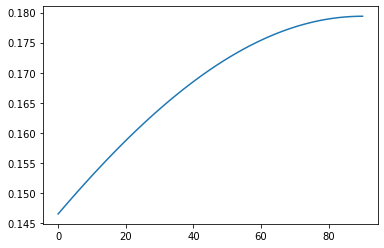

In [14]:
plt.plot(slice1)
plt.plot(model([8.06,1.47]))

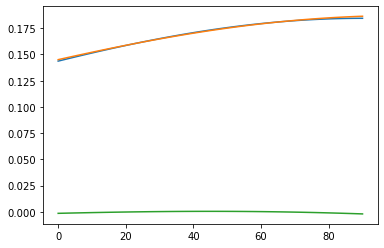

In [186]:
residual = slice1 - model([0.1871,143,102])
plt.plot(slice1)
plt.plot(model([0.1871,143,102]))
plt.plot(residual)

In [14]:
sigmatotal = range(1,90)
sigxtotal = []
residualtotal = []
for i in sigmatotal:
    sigma = i
    A = TDH(0).reshape(360,91)
    slice1 = A[0]
    slice1 = np.array(slice1)
    sigma1 = np.std(slice1)
    param_names = ['A', 'sigx']
    def my_prior_transform(cube):
        params = cube.copy()

        # transform location parameter: uniform prior
        lo = 0
        hi = 20
        params[0] = cube[0] * (hi - lo) + lo

        lo = 1
        hi = 200
        params[1] = cube[1] * (hi - lo) + lo

        return params
    def my_likelihood(params):
        mo = model1(params)
        diff = mo - slice1
        return -0.5 * np.sum((diff/sigma1)**2)
    sampler = ultranest.ReactiveNestedSampler(param_names, my_likelihood, my_prior_transform)
    result = sampler.run(min_num_live_points=200)
    sigx = np.average((result["samples"].T)[1])
    sigxtotal.append(sigx)
    a = np.average((result["samples"].T)[0])
    residual = slice1 - model1([a,sigx])
    residualtotal.append(residual)

[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-0.0002  .0107..-0.0106]*| it/evals=2480/5131 eff=50.2941% N=200    0  0 0  
[ultranest] Likelihood function evaluations: 5158
[ultranest]   logZ = -7.943 +- 0.1269
[ultranest] Effective samples strategy satisfied (ESS = 790.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.44+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.13 tail:0.01 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-3e-05  0.0090..-0.0089]*| it/evals=2540/4122 eff=64.7629% N=200       0  0  
[ultranest] Likelihood function evaluations: 4131
[ultranest]   logZ = -8.079 +- 0.1401
[ultranest] Effective samples strategy satisfied (ESS = 794.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.14 tail:0.01 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-3e-05  0.0098..-0.0097]*| it/evals=2520/4335 eff=60.9432% N=200     0 0    
[ultranest] Likelihood function evaluations: 4353
[ultranest]   logZ = -8.08 +- 0.1704
[ultranest] Effective samples strategy satisfied (ESS = 818.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.11 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.17, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.17 tail:0.01 total:0.17 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-4e-05  0.0099..-0.0098]*| it/evals=2480/4275 eff=60.8589% N=200        0 0  
[ultranest] Likelihood function evaluations: 4286
[ultranest]   logZ = -7.855 +- 0.1348
[ultranest] Effective samples strategy satisfied (ESS = 800.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.13 tail:0.01 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-2e-05  0.0117..-0.0117]*| it/evals=2540/4304 eff=61.8908% N=200       0    0 
[ultranest] Likelihood function evaluations: 4318
[ultranest]   logZ = -8.18 +- 0.1142
[ultranest] Effective samples strategy satisfied (ESS = 809.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.11 tail:0.01 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-8e-05  0.0100..-0.0100]*| it/evals=2500/4013 eff=65.5652% N=200  0  0 0   0 
[ultranest] Likelihood function evaluations: 4034
[ultranest]   logZ = -7.981 +- 0.1401
[ultranest] Effective samples strategy satisfied (ESS = 820.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.14 tail:0.01 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-3e-05  0.0106..-0.0106]*| it/evals=2420/4114 eff=61.8293% N=200   00  0  00 
[ultranest] Likelihood function evaluations: 4124
[ultranest]   logZ = -7.524 +- 0.1177
[ultranest] Effective samples strategy satisfied (ESS = 780.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.12 tail:0.01 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-7e-05  0.0099..-0.0099]*| it/evals=2475/4044 eff=64.3861% N=200  0    0 0 0   
[ultranest] Likelihood function evaluations: 4045
[ultranest]   logZ = -7.763 +- 0.1261
[ultranest] Effective samples strategy satisfied (ESS = 785.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.11 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.13 tail:0.01 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-2e-06  0.0083..-0.0082]*| it/evals=2565/4212 eff=63.9332% N=200    0  0 0 0 0 
[ultranest] Likelihood function evaluations: 4222
[ultranest]   logZ = -8.279 +- 0.1322
[ultranest] Effective samples strategy satisfied (ESS = 825.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.13 tail:0.01 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-3e-06  0.0090..-0.0090]*| it/evals=2565/4200 eff=64.1250% N=200       0 0  0 0 
[ultranest] Likelihood function evaluations: 4216
[ultranest]   logZ = -8.282 +- 0.1122
[ultranest] Effective samples strategy satisfied (ESS = 781.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.11 tail:0.01 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-6e-05  0.0123..-0.0123]*| it/evals=2520/4211 eff=62.8272% N=200       0 0 0 0 
[ultranest] Likelihood function evaluations: 4232
[ultranest]   logZ = -8.08 +- 0.1583
[ultranest] Effective samples strategy satisfied (ESS = 811.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.11 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.16, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.16 tail:0.01 total:0.16 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-4e-05  0.0120..-0.0120]*| it/evals=2580/4304 eff=62.8655% N=200    0 0    0 0  
[ultranest] Likelihood function evaluations: 4323
[ultranest]   logZ = -8.389 +- 0.1398
[ultranest] Effective samples strategy satisfied (ESS = 813.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.14 tail:0.01 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-6e-05  0.0092..-0.0091]*| it/evals=2580/4236 eff=63.9247% N=200    0  0 0 0  0  
[ultranest] Likelihood function evaluations: 4247
[ultranest]   logZ = -8.345 +- 0.1235
[ultranest] Effective samples strategy satisfied (ESS = 807.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.12 tail:0.01 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-1e-05  0.0100..-0.0099]*| it/evals=2520/4155 eff=63.7168% N=200     0 0 0 0 0  
[ultranest] Likelihood function evaluations: 4172
[ultranest]   logZ = -8.059 +- 0.1447
[ultranest] Effective samples strategy satisfied (ESS = 813.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.14 tail:0.01 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-2e-05  0.0094..-0.0092]*| it/evals=2610/4321 eff=63.3341% N=200  0   0   00 0  
[ultranest] Likelihood function evaluations: 4333
[ultranest]   logZ = -8.482 +- 0.1389
[ultranest] Effective samples strategy satisfied (ESS = 803.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.13 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.14 tail:0.01 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-8e-06  0.0081..-0.0080]*| it/evals=2580/4221 eff=64.1631% N=200      0    00 0  
[ultranest] Likelihood function evaluations: 4231
[ultranest]   logZ = -8.31 +- 0.1087
[ultranest] Effective samples strategy satisfied (ESS = 788.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.11 tail:0.01 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-2e-05  0.0094..-0.0094]*| it/evals=2565/4121 eff=65.4170% N=200    0 0   00 0   
[ultranest] Likelihood function evaluations: 4124
[ultranest]   logZ = -8.22 +- 0.1298
[ultranest] Effective samples strategy satisfied (ESS = 783.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.13 tail:0.01 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-1e-05  0.0108..-0.0107]*| it/evals=2655/4570 eff=60.7551% N=200      0 0  0     
[ultranest] Likelihood function evaluations: 4570
[ultranest]   logZ = -8.669 +- 0.1507
[ultranest] Effective samples strategy satisfied (ESS = 780.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.14 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.20 bs:0.15 tail:0.01 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-2e-05  0.0117..-0.0117]*| it/evals=2600/4287 eff=63.6163% N=200      0  0 00   
[ultranest] Likelihood function evaluations: 4317
[ultranest]   logZ = -8.48 +- 0.1485
[ultranest] Effective samples strategy satisfied (ESS = 788.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.44+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.15 tail:0.01 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-9e-06  0.0099..-0.0098]*| it/evals=2640/4256 eff=65.0888% N=200    0  0 0 0    
[ultranest] Likelihood function evaluations: 4277
[ultranest]   logZ = -8.67 +- 0.1479
[ultranest] Effective samples strategy satisfied (ESS = 788.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.11 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.20 bs:0.15 tail:0.01 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-4e-05  0.0118..-0.0118]*| it/evals=2610/4140 eff=66.2437% N=200    0 0  0 0 0  0 
[ultranest] Likelihood function evaluations: 4148
[ultranest]   logZ = -8.459 +- 0.1302
[ultranest] Effective samples strategy satisfied (ESS = 807.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.11 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.13 tail:0.01 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-2e-05  0.0119..-0.0118]*| it/evals=2655/4192 eff=66.5080% N=200       00  0    
[ultranest] Likelihood function evaluations: 4196
[ultranest]   logZ = -8.648 +- 0.2089
[ultranest] Effective samples strategy satisfied (ESS = 825.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.21, need <0.5)
[ultranest]   logZ error budget: single: 0.20 bs:0.21 tail:0.01 total:0.21 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-2e-05  0.0084..-0.0083]*| it/evals=2680/4357 eff=64.4696% N=200    0 0 0  0    0 
[ultranest] Likelihood function evaluations: 4359
[ultranest]   logZ = -8.84 +- 0.1426
[ultranest] Effective samples strategy satisfied (ESS = 836.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.44+-0.14 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.20 bs:0.14 tail:0.01 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-7e-05  0.0126..-0.0126]*| it/evals=2680/4343 eff=64.6874% N=200     0    0 0   0 
[ultranest] Likelihood function evaluations: 4362
[ultranest]   logZ = -8.878 +- 0.1385
[ultranest] Effective samples strategy satisfied (ESS = 798.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.20 bs:0.14 tail:0.01 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-3e-05  0.0103..-0.0102]*| it/evals=2740/4437 eff=64.6684% N=200    0  0 0 0   00 
[ultranest] Likelihood function evaluations: 4441
[ultranest]   logZ = -9.127 +- 0.1524
[ultranest] Effective samples strategy satisfied (ESS = 779.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.20 bs:0.15 tail:0.01 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-5e-05  0.0119..-0.0119]*| it/evals=2680/4319 eff=65.0643% N=200    0 0 0   0 0 0  
[ultranest] Likelihood function evaluations: 4347
[ultranest]   logZ = -8.892 +- 0.1427
[ultranest] Effective samples strategy satisfied (ESS = 809.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.20 bs:0.14 tail:0.01 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-7e-06  0.0126..-0.0126]*| it/evals=2720/4582 eff=62.0721% N=200        0  0 0 0   
[ultranest] Likelihood function evaluations: 4591
[ultranest]   logZ = -9.005 +- 0.145
[ultranest] Effective samples strategy satisfied (ESS = 838.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.11 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.20 bs:0.14 tail:0.01 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-0.0001  .0103..-0.0103]*| it/evals=2680/4475 eff=62.6901% N=200    0   0  0 0 0  
[ultranest] Likelihood function evaluations: 4493
[ultranest]   logZ = -8.872 +- 0.1301
[ultranest] Effective samples strategy satisfied (ESS = 798.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.11 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.20 bs:0.13 tail:0.01 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-3e-07  0.0116..-0.0116]*| it/evals=2800/4689 eff=62.3747% N=200      0 0  0 0 0 0  
[ultranest] Likelihood function evaluations: 4710
[ultranest]   logZ = -9.463 +- 0.1546
[ultranest] Effective samples strategy satisfied (ESS = 780.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.48+-0.13 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.21 bs:0.15 tail:0.01 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-3e-05  0.0086..-0.0086]*| it/evals=2760/4587 eff=62.9132% N=200        0 0 00  0 0 
[ultranest] Likelihood function evaluations: 4594
[ultranest]   logZ = -9.176 +- 0.1403
[ultranest] Effective samples strategy satisfied (ESS = 804.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.20 bs:0.14 tail:0.01 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-6e-05  0.0111..-0.0111]*| it/evals=2840/4562 eff=65.1077% N=200        0 0     0 0 
[ultranest] Likelihood function evaluations: 4588
[ultranest]   logZ = -9.635 +- 0.1489
[ultranest] Effective samples strategy satisfied (ESS = 792.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.48+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.21 bs:0.15 tail:0.01 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-0.0001  .0150..-0.0150]*| it/evals=2790/4656 eff=62.6122% N=200    0 0 0  0 0 0 0 
[ultranest] Likelihood function evaluations: 4667
[ultranest]   logZ = -9.403 +- 0.1482
[ultranest] Effective samples strategy satisfied (ESS = 782.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.21 bs:0.15 tail:0.01 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-5e-05  0.0119..-0.0118]*| it/evals=2726/4297 eff=66.5365% N=200      0 0  00 0 0 0  
[ultranest] Likelihood function evaluations: 4300
[ultranest]   logZ = -9.054 +- 0.1599
[ultranest] Effective samples strategy satisfied (ESS = 781.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.16, need <0.5)
[ultranest]   logZ error budget: single: 0.20 bs:0.16 tail:0.01 total:0.16 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-1e-06  0.0118..-0.0118]*| it/evals=2860/4786 eff=62.3637% N=200        0 0 0   0 0  
[ultranest] Likelihood function evaluations: 4797
[ultranest]   logZ = -9.75 +- 0.1668
[ultranest] Effective samples strategy satisfied (ESS = 809.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.11 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.17, need <0.5)
[ultranest]   logZ error budget: single: 0.21 bs:0.17 tail:0.01 total:0.17 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-4e-05  0.0126..-0.0126]*| it/evals=2790/4547 eff=64.1822% N=200        0 0    0 0 0 
[ultranest] Likelihood function evaluations: 4556
[ultranest]   logZ = -9.372 +- 0.1906
[ultranest] Effective samples strategy satisfied (ESS = 768.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.19, need <0.5)
[ultranest]   logZ error budget: single: 0.21 bs:0.19 tail:0.01 total:0.19 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-5e-06  0.0121..-0.0121]*| it/evals=2860/5071 eff=58.7148% N=200    0   0  0    0 0  
[ultranest] Likelihood function evaluations: 5076
[ultranest]   logZ = -9.741 +- 0.1451
[ultranest] Effective samples strategy satisfied (ESS = 822.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.21 bs:0.15 tail:0.01 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-3e-05  0.0093..-0.0092]*| it/evals=2860/4709 eff=63.4287% N=200          0     0 0  
[ultranest] Likelihood function evaluations: 4729
[ultranest]   logZ = -9.808 +- 0.1431
[ultranest] Effective samples strategy satisfied (ESS = 813.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.21 bs:0.14 tail:0.01 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-5e-05  -0.0113..-0.0112]*| it/evals=2900/4678 eff=64.7611% N=200      00   0 0 0    
[ultranest] Likelihood function evaluations: 4687
[ultranest]   logZ = -9.92 +- 0.1912
[ultranest] Effective samples strategy satisfied (ESS = 824.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.19, need <0.5)
[ultranest]   logZ error budget: single: 0.21 bs:0.19 tail:0.01 total:0.19 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-1e-05  0.0078..-0.0077]*| it/evals=2820/4527 eff=65.1722% N=200    0   0 0  0 0 0  0 
[ultranest] Likelihood function evaluations: 4539
[ultranest]   logZ = -9.577 +- 0.1616
[ultranest] Effective samples strategy satisfied (ESS = 774.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.14 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.16, need <0.5)
[ultranest]   logZ error budget: single: 0.21 bs:0.16 tail:0.01 total:0.16 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-3e-05  0.0135..-0.0134]*| it/evals=2840/4746 eff=62.4725% N=200        0 0    00 0   
[ultranest] Likelihood function evaluations: 4762
[ultranest]   logZ = -9.644 +- 0.1861
[ultranest] Effective samples strategy satisfied (ESS = 791.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.14 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.19, need <0.5)
[ultranest]   logZ error budget: single: 0.21 bs:0.19 tail:0.01 total:0.19 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-4e-06  0.0101..-0.0100]*| it/evals=2760/4551 eff=63.4337% N=200        0 0     0 0  
[ultranest] Likelihood function evaluations: 4553
[ultranest]   logZ = -9.233 +- 0.1347
[ultranest] Effective samples strategy satisfied (ESS = 774.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.44+-0.11 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.20 bs:0.13 tail:0.01 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-3e-06  -0.0129..-0.0129]*| it/evals=2940/4807 eff=63.8159% N=200      00 0    0    
[ultranest] Likelihood function evaluations: 4808
[ultranest]   logZ = -10.09 +- 0.1776
[ultranest] Effective samples strategy satisfied (ESS = 845.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.18, need <0.5)
[ultranest]   logZ error budget: single: 0.21 bs:0.18 tail:0.01 total:0.18 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-2e-05  -0.0094..-0.0094]*| it/evals=2940/4753 eff=64.5728% N=200 0  0  0   0   0   0 
[ultranest] Likelihood function evaluations: 4766
[ultranest]   logZ = -10.18 +- 0.14
[ultranest] Effective samples strategy satisfied (ESS = 783.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.21 bs:0.14 tail:0.01 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-3e-05  0.0106..-0.0105]*| it/evals=2860/4689 eff=63.7113% N=200      0 0   0 0 0  00 
[ultranest] Likelihood function evaluations: 4713
[ultranest]   logZ = -9.762 +- 0.1533
[ultranest] Effective samples strategy satisfied (ESS = 812.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.15 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy wants 198 minimum live points (dlogz from 0.12 to 0.52, need <0.5)
[ultranest]   logZ error budget: single: 0.21 bs:0.15 tail:0.01 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-6e-05  -0.0106..-0.0106]*| it/evals=2925/5037 eff=60.4714% N=200       0    0  0   0 
[ultranest] Likelihood function evaluations: 5049
[ultranest]   logZ = -10.06 +- 0.1696
[ultranest] Effective samples strategy satisfied (ESS = 793.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.17, need <0.5)
[ultranest]   logZ error budget: single: 0.21 bs:0.17 tail:0.01 total:0.17 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-3e-07  -0.0121..-0.0121]*| it/evals=2920/4553 eff=67.0802% N=200       0 0 0   0   0 
[ultranest] Likelihood function evaluations: 4578
[ultranest]   logZ = -10.09 +- 0.1189
[ultranest] Effective samples strategy satisfied (ESS = 828.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.21 bs:0.12 tail:0.01 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-6e-06  0.0095..-0.0094]*| it/evals=2880/5191 eff=57.7039% N=200        0 0 0   0   0 
[ultranest] Likelihood function evaluations: 5213
[ultranest]   logZ = -9.854 +- 0.1454
[ultranest] Effective samples strategy satisfied (ESS = 786.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.21 bs:0.15 tail:0.01 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-2e-05  -0.0098..-0.0097]*| it/evals=2925/4612 eff=66.2965% N=200       0  00  0  00  
[ultranest] Likelihood function evaluations: 4615
[ultranest]   logZ = -10.03 +- 0.1458
[ultranest] Effective samples strategy satisfied (ESS = 830.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.21 bs:0.15 tail:0.01 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-5e-05  -0.0121..-0.0121]*| it/evals=2960/4768 eff=64.7986% N=200       0   0 0 0   0 
[ultranest] Likelihood function evaluations: 4768
[ultranest]   logZ = -10.21 +- 0.1471
[ultranest] Effective samples strategy satisfied (ESS = 780.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.12 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.21 bs:0.15 tail:0.01 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-5e-06  -0.0124..-0.0122]*| it/evals=2925/4678 eff=65.3193% N=200       0 0  0 0  0 0  
[ultranest] Likelihood function evaluations: 4678
[ultranest]   logZ = -10 +- 0.1623
[ultranest] Effective samples strategy satisfied (ESS = 794.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.15 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.16, need <0.5)
[ultranest]   logZ error budget: single: 0.21 bs:0.16 tail:0.01 total:0.16 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-0.0002  0.0109..-0.0109]*| it/evals=2920/5137 eff=59.1452% N=200       0 0 00  0 0 0  
[ultranest] Likelihood function evaluations: 5139
[ultranest]   logZ = -10.03 +- 0.1412
[ultranest] Effective samples strategy satisfied (ESS = 786.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.48+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.21 bs:0.14 tail:0.01 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-2e-05  -0.0105..-0.0104]*| it/evals=2940/4521 eff=68.0398% N=200       0  00 0 0 0 0 0 
[ultranest] Likelihood function evaluations: 4541
[ultranest]   logZ = -10.15 +- 0.1473
[ultranest] Effective samples strategy satisfied (ESS = 820.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.21 bs:0.15 tail:0.01 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-2e-05  -0.0133..-0.0133]*| it/evals=2920/4714 eff=64.6876% N=200    0  0 0 0  0 0 0  0 
[ultranest] Likelihood function evaluations: 4739
[ultranest]   logZ = -10.06 +- 0.1585
[ultranest] Effective samples strategy satisfied (ESS = 820.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.20 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.16, need <0.5)
[ultranest]   logZ error budget: single: 0.21 bs:0.16 tail:0.01 total:0.16 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-3e-06  -0.0130..-0.0128]*| it/evals=2960/4673 eff=66.1748% N=200       0   0  0 0  0 0 
[ultranest] Likelihood function evaluations: 4673
[ultranest]   logZ = -10.17 +- 0.1388
[ultranest] Effective samples strategy satisfied (ESS = 794.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.11 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.21 bs:0.14 tail:0.01 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-2e-05  -0.0119..-0.0118]*| it/evals=3000/4955 eff=63.0915% N=200      00 0 0 0 0   0 0 
[ultranest] Likelihood function evaluations: 4964
[ultranest]   logZ = -10.4 +- 0.1659
[ultranest] Effective samples strategy satisfied (ESS = 835.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.17, need <0.5)
[ultranest]   logZ error budget: single: 0.22 bs:0.17 tail:0.01 total:0.17 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-0.0001  .0094..-0.0093]*| it/evals=2880/4451 eff=67.7488% N=200  0     0 0 0  0 0  0 0 
[ultranest] Likelihood function evaluations: 4453
[ultranest]   logZ = -9.863 +- 0.2014
[ultranest] Effective samples strategy satisfied (ESS = 805.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.12 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy wants 198 minimum live points (dlogz from 0.16 to 0.63, need <0.5)
[ultranest]   logZ error budget: single: 0.21 bs:0.20 tail:0.01 total:0.20 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-1e-05  -0.0112..-0.0112]*| it/evals=2920/5012 eff=60.6816% N=200       0    0 0    00 0  
[ultranest] Likelihood function evaluations: 5012
[ultranest]   logZ = -9.926 +- 0.1347
[ultranest] Effective samples strategy satisfied (ESS = 811.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.21 bs:0.13 tail:0.01 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-0.0002  0.0099..-0.0098]*| it/evals=3060/4780 eff=66.8122% N=200       0    0 0      0  
[ultranest] Likelihood function evaluations: 4802
[ultranest]   logZ = -10.76 +- 0.164
[ultranest] Effective samples strategy satisfied (ESS = 830.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.12 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.16, need <0.5)
[ultranest]   logZ error budget: single: 0.22 bs:0.16 tail:0.01 total:0.16 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-2e-05  -0.0087..-0.0087]*| it/evals=2960/4720 eff=65.4867% N=200       0    0  00  0 0 0 
[ultranest] Likelihood function evaluations: 4730
[ultranest]   logZ = -10.26 +- 0.15
[ultranest] Effective samples strategy satisfied (ESS = 813.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.21 bs:0.15 tail:0.01 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-3e-05  -0.0099..-0.0099]*| it/evals=3060/5102 eff=62.4235% N=200       0    0 0    00 0  
[ultranest] Likelihood function evaluations: 5118
[ultranest]   logZ = -10.77 +- 0.1401
[ultranest] Effective samples strategy satisfied (ESS = 842.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.22 bs:0.14 tail:0.01 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-7e-06  -0.0076..-0.0076]*| it/evals=3080/5150 eff=62.2222% N=200    0  0   0 0 0   0 00  
[ultranest] Likelihood function evaluations: 5157
[ultranest]   logZ = -10.8 +- 0.1739
[ultranest] Effective samples strategy satisfied (ESS = 786.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.13 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.17, need <0.5)
[ultranest]   logZ error budget: single: 0.22 bs:0.17 tail:0.01 total:0.17 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-1e-06  -0.0138..-0.0138]*| it/evals=3000/4964 eff=62.9723% N=200       0   0 0     0 0  
[ultranest] Likelihood function evaluations: 4972
[ultranest]   logZ = -10.46 +- 0.1821
[ultranest] Effective samples strategy satisfied (ESS = 813.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.18, need <0.5)
[ultranest]   logZ error budget: single: 0.22 bs:0.18 tail:0.01 total:0.18 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-2e-05  -0.0108..-0.0107]*| it/evals=2960/4892 eff=63.0861% N=200    0  0 0 0  00 0 0 0  
[ultranest] Likelihood function evaluations: 4892
[ultranest]   logZ = -10.25 +- 0.2261
[ultranest] Effective samples strategy satisfied (ESS = 817.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.23, need <0.5)
[ultranest]   logZ error budget: single: 0.21 bs:0.23 tail:0.01 total:0.23 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-1e-05  -0.0121..-0.0121]*| it/evals=3000/4635 eff=67.6437% N=200       0   0  0  00  0  
[ultranest] Likelihood function evaluations: 4668
[ultranest]   logZ = -10.51 +- 0.1349
[ultranest] Effective samples strategy satisfied (ESS = 809.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.22 bs:0.13 tail:0.01 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-2e-06  -0.0133..-0.0132]*| it/evals=3100/4710 eff=68.7361% N=200   0   0  0  0 0  00  0  
[ultranest] Likelihood function evaluations: 4730
[ultranest]   logZ = -10.98 +- 0.1473
[ultranest] Effective samples strategy satisfied (ESS = 847.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.22 bs:0.15 tail:0.01 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-9e-05  -0.0082..-0.0082]*| it/evals=3105/4946 eff=65.4235% N=200   00      00 0  0 0     
[ultranest] Likelihood function evaluations: 4947
[ultranest]   logZ = -10.96 +- 0.1803
[ultranest] Effective samples strategy satisfied (ESS = 775.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.44+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.18, need <0.5)
[ultranest]   logZ error budget: single: 0.22 bs:0.18 tail:0.01 total:0.18 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-7e-05  -0.0109..-0.0108]*| it/evals=3160/4847 eff=68.0009% N=200           0   0  0 0    
[ultranest] Likelihood function evaluations: 4854
[ultranest]   logZ = -11.27 +- 0.1531
[ultranest] Effective samples strategy satisfied (ESS = 787.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.12 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.23 bs:0.15 tail:0.01 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-0.0002  0.0128..-0.0128]*| it/evals=3080/4567 eff=70.5290% N=200   0   0   0  0 0  0    
[ultranest] Likelihood function evaluations: 4569
[ultranest]   logZ = -10.78 +- 0.174
[ultranest] Effective samples strategy satisfied (ESS = 849.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.11 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy wants 198 minimum live points (dlogz from 0.13 to 0.50, need <0.5)
[ultranest]   logZ error budget: single: 0.22 bs:0.17 tail:0.01 total:0.17 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-2e-06  -0.0165..-0.0163]*| it/evals=2980/4773 eff=65.1651% N=200       0  0 0 0   00 0  
[ultranest] Likelihood function evaluations: 4786
[ultranest]   logZ = -10.32 +- 0.1511
[ultranest] Effective samples strategy satisfied (ESS = 808.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.14 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.22 bs:0.15 tail:0.01 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-2e-05  -0.0097..-0.0096]*| it/evals=3120/4999 eff=65.0135% N=200      0 0  0   0  0 0    
[ultranest] Likelihood function evaluations: 5022
[ultranest]   logZ = -11.07 +- 0.1573
[ultranest] Effective samples strategy satisfied (ESS = 849.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.11 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.16, need <0.5)
[ultranest]   logZ error budget: single: 0.22 bs:0.16 tail:0.01 total:0.16 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-6e-05  -0.0127..-0.0127]*| it/evals=3100/4974 eff=64.9351% N=200    0      0 0  0 0  0   
[ultranest] Likelihood function evaluations: 4978
[ultranest]   logZ = -10.95 +- 0.1754
[ultranest] Effective samples strategy satisfied (ESS = 832.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.13 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy wants 198 minimum live points (dlogz from 0.14 to 0.53, need <0.5)
[ultranest]   logZ error budget: single: 0.22 bs:0.18 tail:0.01 total:0.18 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-0.0001  0.0094..-0.0094]*| it/evals=3060/5013 eff=63.5778% N=200 0     0   0  0 0   0    
[ultranest] Likelihood function evaluations: 5029
[ultranest]   logZ = -10.76 +- 0.1676
[ultranest] Effective samples strategy satisfied (ESS = 798.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.11 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.17, need <0.5)
[ultranest]   logZ error budget: single: 0.22 bs:0.17 tail:0.01 total:0.17 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-8e-05  -0.0125..-0.0124]*| it/evals=3040/5030 eff=62.9400% N=200        0  0    0  0   0 
[ultranest] Likelihood function evaluations: 5050
[ultranest]   logZ = -10.64 +- 0.19
[ultranest] Effective samples strategy satisfied (ESS = 809.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy wants 198 minimum live points (dlogz from 0.15 to 0.59, need <0.5)
[ultranest]   logZ error budget: single: 0.22 bs:0.19 tail:0.01 total:0.19 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-4e-05  -0.0092..-0.0092]*| it/evals=3080/4807 eff=66.8548% N=200       0  0 0 0  0 0    0 
[ultranest] Likelihood function evaluations: 4836
[ultranest]   logZ = -10.89 +- 0.1439
[ultranest] Effective samples strategy satisfied (ESS = 828.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.11 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.22 bs:0.14 tail:0.01 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-2e-06  -0.0103..-0.0103]*| it/evals=3040/4699 eff=67.5706% N=200           0  0 0  00  00 
[ultranest] Likelihood function evaluations: 4706
[ultranest]   logZ = -10.63 +- 0.1612
[ultranest] Effective samples strategy satisfied (ESS = 760.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.11 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.16, need <0.5)
[ultranest]   logZ error budget: single: 0.22 bs:0.16 tail:0.01 total:0.16 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-4e-05  -0.0084..-0.0084]*| it/evals=3080/5121 eff=62.5889% N=200        0  0 0 0   0   0 
[ultranest] Likelihood function evaluations: 5139
[ultranest]   logZ = -10.83 +- 0.2066
[ultranest] Effective samples strategy satisfied (ESS = 821.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.13 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.21, need <0.5)
[ultranest]   logZ error budget: single: 0.22 bs:0.21 tail:0.01 total:0.21 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-2e-05  -0.0080..-0.0078]*| it/evals=3015/5036 eff=62.3449% N=200   0  0    0   0  0     0 
[ultranest] Likelihood function evaluations: 5039
[ultranest]   logZ = -10.47 +- 0.1633
[ultranest] Effective samples strategy satisfied (ESS = 818.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.14 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.16, need <0.5)
[ultranest]   logZ error budget: single: 0.22 bs:0.16 tail:0.01 total:0.16 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-5e-05  -0.0121..-0.0121]*| it/evals=3120/4961 eff=65.5325% N=200        0  0 0 0  0   0 
[ultranest] Likelihood function evaluations: 4989
[ultranest]   logZ = -11.04 +- 0.1735
[ultranest] Effective samples strategy satisfied (ESS = 812.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.17, need <0.5)
[ultranest]   logZ error budget: single: 0.22 bs:0.17 tail:0.01 total:0.17 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-4e-05  -0.0079..-0.0078]*| it/evals=3060/4875 eff=65.4545% N=200        0  0 00  0 0 0 0 0 
[ultranest] Likelihood function evaluations: 4895
[ultranest]   logZ = -10.78 +- 0.1989
[ultranest] Effective samples strategy satisfied (ESS = 793.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.14 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.20, need <0.5)
[ultranest]   logZ error budget: single: 0.22 bs:0.20 tail:0.01 total:0.20 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-3e-05  -0.0087..-0.0087]*| it/evals=3040/4712 eff=67.3759% N=200 0   0     0 0  00 0 0 0  
[ultranest] Likelihood function evaluations: 4734
[ultranest]   logZ = -10.7 +- 0.1838
[ultranest] Effective samples strategy satisfied (ESS = 776.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.18, need <0.5)
[ultranest]   logZ error budget: single: 0.22 bs:0.18 tail:0.01 total:0.18 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-0.0002  0.0111..-0.0109]*| it/evals=3060/4919 eff=64.8442% N=200       0   0 0  200 0 0 0  
[ultranest] Likelihood function evaluations: 4926
[ultranest]   logZ = -10.73 +- 0.1486
[ultranest] Effective samples strategy satisfied (ESS = 792.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.14 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.22 bs:0.15 tail:0.01 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-5e-05  -0.0105..-0.0105]*| it/evals=3105/5021 eff=64.4057% N=200            0 0 0   0 0 0  
[ultranest] Likelihood function evaluations: 5031
[ultranest]   logZ = -11.04 +- 0.1856
[ultranest] Effective samples strategy satisfied (ESS = 827.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.19, need <0.5)
[ultranest]   logZ error budget: single: 0.22 bs:0.19 tail:0.01 total:0.19 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-3e-05  -0.0102..-0.0102]*| it/evals=3140/4958 eff=65.9941% N=200        0  0 0 0  00 0 0  
[ultranest] Likelihood function evaluations: 4966
[ultranest]   logZ = -11.09 +- 0.1269
[ultranest] Effective samples strategy satisfied (ESS = 801.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.12 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.22 bs:0.13 tail:0.01 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-4e-05  -0.0115..-0.0114]*| it/evals=3160/4978 eff=66.1365% N=200   0    0  0 0  0 0 00 0 0  
[ultranest] Likelihood function evaluations: 4995
[ultranest]   logZ = -11.26 +- 0.1675
[ultranest] Effective samples strategy satisfied (ESS = 804.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.17, need <0.5)
[ultranest]   logZ error budget: single: 0.23 bs:0.17 tail:0.01 total:0.17 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-8e-06  -0.0107..-0.0106]*| it/evals=3220/5092 eff=65.8217% N=200        0  0 00 0 00 0 0 0 
[ultranest] Likelihood function evaluations: 5097
[ultranest]   logZ = -11.47 +- 0.1896
[ultranest] Effective samples strategy satisfied (ESS = 807.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy wants 198 minimum live points (dlogz from 0.15 to 0.56, need <0.5)
[ultranest]   logZ error budget: single: 0.23 bs:0.19 tail:0.01 total:0.19 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-0.0001  0.0104..-0.0104]*| it/evals=3160/4976 eff=66.1642% N=200   0    0  0 0  0  0 0  0  
[ultranest] Likelihood function evaluations: 4987
[ultranest]   logZ = -11.19 +- 0.1984
[ultranest] Effective samples strategy satisfied (ESS = 783.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.11 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.20, need <0.5)
[ultranest]   logZ error budget: single: 0.23 bs:0.20 tail:0.01 total:0.20 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-0.0001  0.0103..-0.0103]*| it/evals=3120/4863 eff=66.9097% N=200        00  0 0 00  00 0 0  
[ultranest] Likelihood function evaluations: 4876
[ultranest]   logZ = -11.06 +- 0.1562
[ultranest] Effective samples strategy satisfied (ESS = 809.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.16, need <0.5)
[ultranest]   logZ error budget: single: 0.22 bs:0.16 tail:0.01 total:0.16 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-5e-05  -0.0119..-0.0119]*| it/evals=3080/5172 eff=61.9469% N=200   0    0  00   0   0  00 
[ultranest] Likelihood function evaluations: 5192
[ultranest]   logZ = -10.91 +- 0.1498
[ultranest] Effective samples strategy satisfied (ESS = 804.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.22 bs:0.15 tail:0.01 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-0.0001  0.0118..-0.0117]*| it/evals=3140/4921 eff=66.5113% N=200        0  0 0 0   0 0  0   
[ultranest] Likelihood function evaluations: 4937
[ultranest]   logZ = -11.17 +- 0.1963
[ultranest] Effective samples strategy satisfied (ESS = 794.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.13 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy wants 198 minimum live points (dlogz from 0.15 to 0.56, need <0.5)
[ultranest]   logZ error budget: single: 0.23 bs:0.20 tail:0.01 total:0.20 required:<0.50
[ultranest] done iterating.


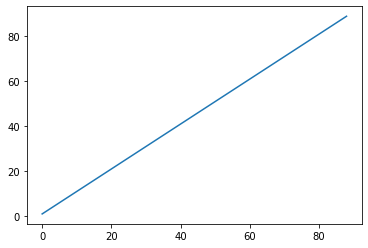

In [15]:
plt.plot(sigmatotal)

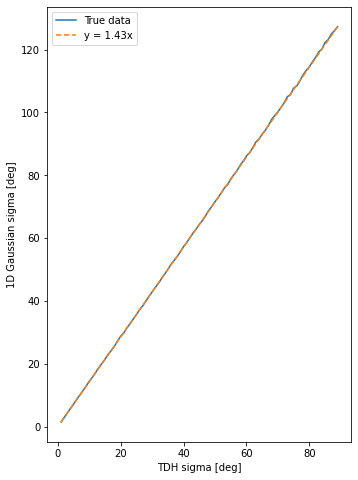

In [18]:
plt.figure(figsize = (8,8))
plt.plot(sigmatotal, sigxtotal, label = "True data")
plt.plot(sigmatotal, 1.43*np.array(sigmatotal), label = 'y = 1.43x', linestyle = 'dashed')
plt.xlabel("TDH sigma [deg]")
plt.ylabel("1D Gaussian sigma [deg]")
plt.legend()
plt.axis('scaled')
plt.savefig("sigma relation")

In [20]:
np.savetxt('sigexplore.csv', sigxtotal, delimiter=',')

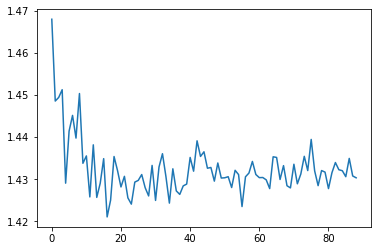

In [294]:
plt.plot(np.array(sigxtotal)/np.array(sigmatotal))

In [295]:
np.average(np.array(sigxtotal)/np.array(sigmatotal))

1.4325556634750685